$\renewcommand{\v}[1]{\boldsymbol{#1}}
\renewcommand{\vect}[1]{\text{vec}\left({#1}\right)}
\renewcommand{\l}[1]{^{(#1)}}
\newcommand{\pd}[2]{\frac{\partial #1}{\partial #2}}
$


CS 370 Final Project

# Introduction
The Navier-Stokes equations are a set of partial differential equations
that have been found to describe the dynamics of
real-world fluids remarkably
well.
Using numerical approximation schemes, these set of 
differential equations have
been used to simulate fluids in engineering and 
computer graphics.
However achieving real-time performance with traditional methods typically
comes at the cost of physical accuracy, or requires
powerful hardware
The goal of this project
is twofold: (1) to build a 3D U-net based network
and train a model using unsupervised learning
methods that is capable of efficiently
simulating incompressible fluid flow in a fixed 
region,
and (2) explore the U-net/CNN architecture.
This implementation aspect of this project will 
largely be based off [1] and [2].

This report is organized into two main parts.
The first part covers the CNN/U-net architecture
and the second covers the implementation of
the actual fluid model, along with related aspects
of the theory.

# Convolutions and Convolutional Neural Networks (CNNs)

At the heart of CNNs is the discrete _cross-correlation_ operation.
Given a 2D matrix of values $I$
and a filter $K$, the 
cross-correlation of $I$ and $K$ is given by

$$
(I\star K)_{i,j} := \sum_{u}\sum_{v}K_{u,v}
I_{i+u,j+v}
$$
where $u,v$ are allowed to range over all possible values.
This operation is often reffered to as a _convolution_, though
the formal definition of a covolution of $I$ and $K$ denoted $I*K$ differs from $I\star K$ only in the 'flipping' of the 
kernel/filter as it is convolved over the image (which makes
$*$ commutative).

In the most basic form, convolving $I\in \mathbb{R}^
{n_1\times n_2}$ matrix by a $K\in \mathbb{R}^{h_1\times h_2}$ kernel results in a output in $\mathbb{R}^{(n_1-h_1+1)\times
(n_2-h_2+1)}$. 
Addtionally, the input image $I$ can be padded with $p$ 
entries (usually with zeros) around the borders or the kernel
may be strided an amount $s$ so that the kernel skips over
$s-1$ locations.
With these modification, the size of the $i$-th output dimension
comes out to $\lfloor(n_i-h_i+2p_i)/s_i\rfloor+1$.



## Layers

If $l$ is a convolutional layer, then its input is taken to
consist of $m_1^{(l-1)}$ feature maps each of size
$m_2^{(l-1)}\times m_3^{(l-1)}$, i.e input is a rank-3 tensor
with dimensions $m_1^{(l-1)}\times m_2^{(l-1}\times m_3^{(l-1)}$.
Analogous to a nueron in a fully-connected layer, the output
$Y^{(l)}$ of the convolutional layer consists of $m_1^{(l)}$ feature maps of size
$m_2^{(l)}\times m_3^{(l)}$, one for each filter.
The $i$-th feature map of $Y^{(l)}$ is computed by
summing the result of the kernel $K_{i,j}^{(l)}$ convolved over 
all $m_1^{(l-1)}$ input feature maps, plus a bias matrix 
followed by a non-linear map $f_i$.
$$
Y_{i}^{(l)} := f_i^{(l)}\left(B_i^{(l)} + \sum_{j=1}^{m_1^{(l-1)}}K_{i,j}^{(l)} \star Y_j^{(l-1)}\right).
$$

Notice that the layer consists of $m_1^{(l-1)}\times m_1^{(l)}$
filters with $K_{i,j}^{(l)}$ filter connecting the $i$-th input
feature map to the $j$-th output feature map.
It is also common to have $K_{i,j_1}^{(l)} = K_{i,j_2}^{(l)}$
for any $j_1,j_2$ which reduces the number of unique filters
to $m_1^{(l)}$.

Pooling/subsampling layers have much the same form except the 
convolution operation is
repalced by an operation that returns the maximum value 
(max pooling layer), the average (average pooling layer), or
some other sample.



## Why Convolutions?

Convolving a given input image $I$ with a relatively simple kernels like the one shown below can allow us extract 
rudimentary features like
vertical/horizontal/angled edges. For the particual Sobel filter $K$ below, the value $(I \star K)_{i,j}$ will only
have a large magnitude if the values $I_{i+1,j-1\,:\,j+1}$
differ greatly from $I_{i-1,j-1\,:\,j+1}$,
or in other words if $I_{i,j}$ is  part of a sharp vertical edge.

$$
K = \begin{bmatrix}
1 & 0 & -1\\
2 & 0 & -2\\
1 & 0 & -1
\end{bmatrix}
$$

By allowing for a bias term and also composing the result
with a non-linear map like the ReLU, we can expand the space of
possible features that result in a large activation.
Furthermore, by doing this over several layers and by learning 
the kernel weights we can learn to activate only more complex
patterns composed to many edges and shapes.
These activations can then be used in even later layers
to activate for more abstract objects like cars.

An advantage of convolutional layers over fully-connected layers
comes through _parameter sharing_ which refers to the fact
that the same weights are used in mutliple spatial locations.
In a fully-connected layer a single parameter weight 
$W_{j,i}^{(l)}$ 
is only used to connect the $i$-th activation from the layer $l-1$ to the
$j$-th activation from layer $l$, whereas in a convolutional
layer a single weight in a kernel $K_{i,j}^{(l)}$ will connect
numerous activations from layer $l-1$ to those from layer $l$
as ther kernel is convolved over the input feature maps.

The parameter sharing and the structure of a convolutional
layer means that the network is better served using the same 
set of parameters to extract the same features from
different spatial locations in the input feature map,
as opposed to being forced to use disjoint parameters accomplish
the same task.
For example, the same set of parameters used in the 
Sobel kernel from earlier could be used pass along large
activations for vertical edges detected in various spatial 
locations in the input feature map to the output feature map.

Lastly, parameter sharing also has the benefit of lowering
memory and computation costs during the backward propogation
due to the sparse connectively.

If a convolutional layer consists of pooling operations, then
it will help make the activations in the output approximately
invariant to small translations in the input.
This is due to the inherent characterics of a pooling operation
which extract a summary statistic from a neighborhood of
values.
Resistance to translations in the input is
often helpful in image recognization applications where 
detecting the presence of an object/feature is paramount.

## Transpose Convolutions and Deconvolutional Layers
The convolution operation is linear in the sense that
convolving a null image (all zeros) with any kernel
results in a null image of appropriate dimensions, and
the $(I_1+I_2)\star K = I_1\star K + I_2 \star K$.
Therefore we can recast convolving an $\v{x}^{(l)}\in 
\mathbb{R}^{n_1\l{l}\times n_2\l{l}}$ with $K\in 
\mathbb{R}^{h_1\times h_2}$  as a matrix multiplication 
between $\vect{x}\l{l}\in \mathbb{R}^{n_1\l{l}n_2\l{l}}$ and a 
matrix $C_K\in\mathbb{R}^{n_1\l{l+1}n_2\l{l+1}\times 
n_1\l{l}n_2\l {l}}$.
This means that if we let $\vec{y}\l{l}=\vec{x}\l{l}\star K$
, then we would have $\vect{\vec{y}\l{l}} = C_K\vect{\vec{x}
\l{l}}$. As a side node, if $\vec{x}\l{l}$ is a tensor consists 
of multiple channels, then $C_K$ could be repeated across 
another dimension to achieve the same effect.



The matrix $C_K$, which does the same transformation as
convolution by kernel $K$, maps vectors from a higher dimension
$\mathbb{R}^{n_1\l{l}n_2\l{l}}$ to a lower dimension
$\mathbb{R}^{n_1\l{l+1}n_2\l{l+1}}$ but its transpose $C_K^T$
would do the opposite. This is the idea behind a _transpose
convolution_ and can be used to upscale images.

The transpose convolution operation is also sometimes called 
a _deconvolution_, although that name is misleading since
the operation as described has nothing to do with finding
an inverse input image $I$ that results in a given output
image $Y$ for a given kernel $K$ ( i.e $I \star K = Y$).



As an additional note, actual implementation of the convolution
operation do not vectorize the input image
 but rather tend to vectorize the kernel $K$.
Exploiting the fact that the each value in the output of a 
convolution is the 
dot product of a local region in input image
with $K$, a convolution operation between
$\vec{y}\l{l} = \vec{x}\l{l}\star K$ can be equivalently
rewritten as $\vect{\vec{y}\l{l}} = \phi(\vec{x}\l{l})\vect{K}$
where $\phi(\vec{x}\l{l})$ is an expanded matrix constructed
using this fact.
For example for $\vec{x}\l{l}\in\mathbb{R}^{5\times 5}$, the
corresponding expanded matrix for a kernel $K\in\mathbb
{R}^{2\times 2}$ is given  below.
$$
\vec{x}\l{l} = 
\begin{bmatrix}
\color{red}{x_{1,1}} & \color{red}{x_{1,2}} & x_{1,3} 
& x_{1,4} & x_{1,5}\\
\color{red}{x_{2,1}} & \color{red}{x_{2,2}} & x_{2,3} & x_{2,4} & x_{2,5}\\
x_{3,1} & x_{3,2} & x_{3,3} & x_{3,4} & x_{3,5}\\
x_{4,1} & x_{4,2} & x_{4,3} & 
\color{green}{x_{4,4}} & \color{green}{x_{4,5}}\\
x_{5,1} & x_{5,2} & x_{5,3} & 
\color{green}{x_{5,4}} & \color{green}{x_{5,5}}
\end{bmatrix}
\qquad
\phi(\vec{x}\l{l}) = 
\begin{bmatrix}
\color{red}{x_{1,1}} & \color{red}{x_{1,2}} & 
\color{red}{x_{2,1}} & \color{red}{x_{2,2}}\\
x_{1,2}& x_{1,3}& x_{2,2}& x_{2,3}\\
x_{1,3} & x_{1,4} & x_{2,3} & x_{2,4}\\
\vdots & \vdots & \vdots & \vdots \\
\color{green}{x_{4,4}} & \color{green}{x_{4,5}} & 
\color{green}{x_{5,4}} & \color{green}{x_{5,5}}
\end{bmatrix}
$$



This expansion can be modified to account for non-zero padding, 
non-unit strides, and multiple channels but the basic structure 
is the same.
The transpose of this operation 
(i.e $\phi(\v{x}\l{l})^T$) ca be achieved in
PyTorch easily via
[`torch.nn.Unfold`](https://pytorch.org/docs/stable/generated/torch.nn.Unfold.html#torch.nn.Unfold).


The transpose convolution is also sometimes said to be a
forward convolution "played backwards" because if a
forward convolution is computed as 
$\vect{\vec{y}\l{l}} = C_K\vect{\vec{x}\l{l}}$
the the backward pass would give 
$\pd{\vec{y}\l{l}}{\vec{x}\l{l}} = C_K^T$,
and conversely a transpose convolution computed as 
$\vect{\vec{y}\l{l}} = C_K^T\vect{\vec{x}\l{l}}$
would give
$\pd{\vec{y}\l{l}}{\vec{x}\l{l}} = C_K$ for the backward pass.

A convolutional layer can be made into a _deconvolutional_ layer (or more accurately tranpose-convolutional layer)
by using the filter $K_{i,j}$ to preform
a transpose-convolution operation on the input feature map
instead of convolution.
These layers can be used to efficiently 
upsample the dimensions of the feature map from one layer
to the next.

## Fully Convolutional Networks

CNNs have been used for dense prediction tasks like image 
segmentation where a network must output a prediction for a
large number, if not all, spatial locations throughout the 
input feature map.
A Fully Convolutional Network (FCN) which only involves a
slight modification to a traditional CNN that has turned out
to be effective for these kinds of tasks.

Recall that in traditional CNN typically consists of a sequence
of convolutional/pooling layers followed by fully-connected
layers.
The use of a fully-connected layer towards the ends means that
the network can only take inputs of a fixed size since
a fully-connected layer of $N$ neurons accepts only inputs
$\vec{x}\l{l}$ satisfying $\vect{\vec{x}\l{l}}\in \mathbb{R}^N$.
Addtionally spatial information is also lost since the receptive
field of all the units in the fully-connected layer is the
same.

If we tranform the fully-connected layer into a deconvoutional 
layer that upsamples the dimensions of the feature map, we
arrive at a FCN that can accept arbritary sized input and
produce an output of corresponding spatial dimensions.
The loss function for this network would be the sum of the 
individual losses over the spatial dimensions of the output 
$\vec{y}\l{L}$ of the final layer $L$, $\mathcal{L}(\vec{x}\l{0}
;\vec{\theta}) = \sum_{k,i,j}\ell(\vec{y}\l{L}_{k,i,j};
\vec{\theta})$.

With only upsampling layers following the convolutional layers,
the spatial resolution of the predictions tends to be quite 
poor due to the large receptive fields in the later layers.
It turns out that sampling from previous layers
with much smaller receptive fields improves the spatial
resolution significantly.
In this scheme, we take the output feature map with 
$d\l{l_1}$ channels from an earlier pooling
layer and concatenate it to the input of a upsampling layer
that used to take input feature maps with $d\l{l_2}$ channels.
The input feature maps to that upsampling layer will then
consist of $d\l{l_1} + d\l{l_2}$ channels.
These form a kind of 'skip' connection from earlier
layers to the later ones and provide the later 
layers with finer local features that might have gotten
'washed' out due to their larger receptive fields.





## U-nets
A U-net architecture is essentially a FCN with a sepcific 
(unique) structure to its layers.
The network begins with a contracting series of layers
(meaning the feature maps in succesive layers have
expanding number of channels and contracting width and height)
consisting of convolutions/pooling layers followed by
expansive series of layers consisting of convolutional/
upsampling layers.
Typically, each step of the contracting path consists of 
multiple $3\times 3$
unpadded convolutions (so only number of channels in 
output feature map changes) followed by a $2\times 2$
max pooling operation. Note that each convolution
always followed by a ReLU unit for non-linearity.
The output channel sizes for the convolutions are chosen
so that the number of channels in the feature map doubles
at every step of the contracting path.
In a much similar fashion, each step of the expansive path 
consists of the same 3x3 convolutions following by a
upsampling layer (transpose-convolution layer).
The upsampling layer halves the number of channels
in the feature map but configuration of output channels is chosen so that
the number of channels output feature map after each step
is halved but the output feature map from the corresponding
step in the contracting path is concatenaed to make up the
difference.
Cropping may be neccasary due to the loss of values
the borders of the feature map during the contraction steps.
A diagram of the U-net architecture from the original paper
is given below.

Unlike a traditional FCN, the number of channels in the feature
maps in the upsampling layers remains high.
The number of channels is in fact largely mirrored between the
downsampling and upsampling steps, which  gives the
network a "U" shape (hence the name).
The higher channel depth in the upsampling layers allows
the network to relay more local context to subsequent layers.


![U-net Architecture Diagram](https://i.imgur.com/DR7i6lk.png)
Figure caption: The different colored arrows how the various
operations, and the blue boxes denote multi-channel feature
maps with the number of channels noted on the top in gray
text. The width and height of the feature map is noted
on the bottom.

For a network that needs to output a classification among $n$
categories for each spatial location in the final feature map (which 2 for the network in the diagram above),
a 1x1 convolution can be used to get the desired channel depth.




# Unsupervised Learning for Fluid Dynamics

## Naiver-Stokes for Incompressible Fluids
If we have velocity
$\v{u}=(u_x(x,y,z),u_y(x,y,z),u_z(x,y,z))$ and pressure field
$p = p(x,y,z)$ defined over fluid domain $\Omega\subseteq \mathbb{R}^{w\times h\times d}$, then the set of partial
differential equation that tell us how the velocity and pressure
fields will evolve with time given intial and boundary condition
are the following
$$
\nabla\cdot \v{u}=0\qquad\qquad \rho\frac{D\v{u}}{Dt}= -\nabla 
p + \mu\nabla^2 \v{u}
$$
where


*   $\rho$ and $\mu$ denote the fluid density and fluid velocity
*   $\nabla\cdot \v{u}\quad$ is the incompressiblity condition,
and states that the net amount of fluid entering and exiting
a small enclosed volume must be zero.
*   $\rho\frac{D\v{u}}{Dt}\quad$ describes the product of the
change in the fluid velocity $u$ along a streamline and the
fluid density, which is analogous to $m\v{a} = m\frac{d\v{v}}{dt}$ for a rigid object from Newton's Second Law.
Note that $\frac{D\v{u}}{Dt}$ is defined to be 
rewritten as $\pd{\v{u}}{t}
+(\nabla\cdot \v{u})\v{u}$
*   $-\nabla  p + \mu\nabla^2 \v{u}\quad$ together capture the
forces generated by pressure differences within the fluid and
frictional forces that cause the velocity to tend toward
the local average.

On the boudary of the fluid domain $\partial\Omega$ we
enforce the following Dirichlet boundary condition,
$$
\v{u} = \v{u}_d.
$$



Rather than having the fluid model directly output the velocity
field $\v{u}$ and pressure field $p$, if we have the network
output the vector potential $\v{a}$ and the pressure field $p$
with $\v{u} = \nabla \times a$, then we will automatically
satisfy the incompressibly condition.
We can do this without any loss in generality because a
divergence-less vector field can always be expressed as a curl
of a vector field.

In order to discretize the fluid domain, we essentially sample
values of $\v{a}$ and $p$ at finitely many locations
within $\Omega$.
The sampling that we will use can be represented as a 
Marker-And-Cell (MAC) Grid and this technique is called the
marker-and-cell method.
The MAC grid discretizes the domain into cubes of constant 
width where each cell has a pressure $p$ defined at its center 
, velocity $\v{u}$ defined at the center of its faces, and
$\v{a}$ defined at its edges.
The rational for the staggering of the quantities is
that we can use central differences to approximate the
derivatives which are $O(\Delta x^2)$ accurate
instead of a simple foward or backward difference which are
$O(\Delta x)$ accurate.

Central difference refers to the following approximation of
the derivative
$$
\left.\pd{f}{x}\right|_{x=x_0}\approx \frac{f(x_0+\Delta x) - f(x_0-\Delta x)}{2\Delta x}.
$$

A diagram of the 3D MAC grid from \[1\] is given below, 


![3D MAC Grid](https://i.imgur.com/Yw7Y92g.png)



The laplacian $\nabla^2\v{u}$ needed for the momemtum equation
is calculated using a
[27-point stencil](https://en.wikipedia.org/wiki/Discrete_Laplace_operator#Implementation_via_operator_discretization).

Given $\v{a}^t$, the velocity field at time $t$, $\v{u}^t$ was
calculated on the grid by using foward differences as 
approximaion for first-order derivatives.
Altogether, the derivates in the momemtum equation were handled
as follows:
$$
\rho \left(\frac{\v{u}^{t+dt}-\v{u}^t}{dt}+
\left(\v{u}^{t^\prime}\cdot\nabla \right)\v{u}^{t^\prime}\right)
=
-\nabla p^{t+dt} + \mu\nabla^2\v{u}^{t^\prime}
$$
where $\v{u}^{t^\prime} = \frac{\v{u}^t + \v{u}^{t+dt}}{2}$
as per the
[implict-explict integration scheme](https://en.wikipedia.org/wiki/Explicit_and_implicit_methods) 
which offers
better accuracy than resorting to either
$\v{u}^{t^\prime} = \v{u}^{t+dt}$ or
$\v{u}^{t^\prime} = \v{u}^{t}$.

## Fluid Model
With the discretization out of the way, we now move on to the
fluid model $F$ which maps the fluid state consisting of
the vector potential $\v{a}^t$ and pressure field $p^t$ at
time $t$ to the subsequent state $\v{a}^{t+dt}$ and $p^{t+dt}$
given the domain $\Omega$ and boundary conditions $\v{u}_d$ at
time $t+dt$. Note that the discretized $\Omega$ is essentially
a grid of 1's and 0's that is used as a mask.

We can then recurrently apply $F$ to get the fluid state at all
later time steps.
$$
(\v{a}^{n\,dt}, p^{n\,dt}) = F(\v{a}^{(n-1)\,dt},p^{(n-1)\,dt}
, \Omega^{n\,dt}, \v{u}^{n\,dt})
$$
The exact tensor of feature that were passed into the model
were the following:
$$
\left(p^t, \v{a}^{t},\v{u}^t, \Omega^{t+dt},
\partial\Omega^{t+dt}, \Omega^{t+dt}\cdot\v{u}^{t},
\Omega^{t+dt}\cdot p^{t},
\partial\Omega^{t+dt}\cdot \v{u}_d^{t+dt}\right)
$$
Since all the quanties are defined on a 3D grid of the same 
size, the total size comes out to $19\times D\times H\times W$
where $D, H, W$ are the dimensions of the grid.

The architecture of fluid model itself was a 3D U-net was
adapted from a 2D U-net implementation available 
[here](https://github.com/aschethor/Unsupervised_Deep_Learning_of_Incompressible_Fluid_Dynamics/blob/main/unet_parts.py) using the following 
[paper](https://arxiv.org/pdf/1606.06650.pdf)
on 3D U-net
as reference.

## Loss Function

The loss function used was based on the discretized
Navier-Stokes equation covered earlier. We do not need
to worry about the incompressiblity euqation, only the
momemtum equation and the boundary conditions.
The loss terms are then
$$
\ell_p = \left\Vert
\rho \left(\frac{\v{u}^{t+dt}-\v{u}^t}{dt}+
\left(\v{u}^{t^\prime}\cdot\nabla \right)\v{u}^{t^\prime}\right)
+\nabla p^{t+dt} - \mu\nabla^2\v{u}^{t^\prime}\right\Vert^2
$$
for all points in $\Omega$ and 
$$
\ell_d = \left\Vert
\v{u}_d^{t+dt}-\v{u}^{t+dt}
\right\Vert^2
$$
for all points in $\partial \Omega$.
The total loss would then be $\mathcal{L}= \ell_p + 20\cdot\ell_d$.
The boundary loss was weighted more heavily to discourage
unrealistic velocity fields at the boundaries.

## Training

Training the model involved intializing a set of $M$
randomized domains, initial fields, and boundary conditions:
$\{\Omega_k^0, (\v{u}_d^0)_k, \v{a}_k^0, \v{p}_k\}_{k=1}^M$.
The randomized domains $\Omega^0_k$ consist of the following
primitive shapes: boxes, spinning cylinder, and spheres.
The intial fields were all zeros.

In the actual training loop, every epoch we draw a mini-batch of
$\{\Omega_k^0, (\v{u}_d^0)_k, \v{a}_k^0, \v{p}_k\}$ from the 
dataset of $M$ and recurrently feed it to the network every
iteration.
More precisely, we use the model to predict $\v{a}_k^{t+dt}$
and $p_k^{t+dt}$ for the next time step.
Using the model's prediction, we calculate the error
based on the residuals of the Naiver-Stokes discussed ealier
and update the parameters accordingly.
At the end of each iteration, the datset is updated with
the new vector potential $\v{a}^{t+dt}$ and pressure
field $p^{t+dt}$ predicted by the model.

After a number of epochs the vector potential and pressure 
fields are reset to zero so that the network can learn from
"cold-starts." This seemed to help with lowering the 
overall error according to [1].


# Implementation

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from   torch.utils.data import Dataset, DataLoader

import numpy as np
from numpy.random import rand, randint, randn

import matplotlib.pyplot as plt

import time
import io
import os
from datetime import datetime
import json

Helper functions for moving objects to and from
CUDA memory.

In [ ]:
CUDA = False
device = f'cuda:{torch.cuda.current_device()}' if CUDA else 'cpu'

def cuda(x):
    if not CUDA:
        return x

    if type(x) is tuple or type(x) is list:
        return [xx.cuda() for xx in x]

    return x.cuda() if CUDA else x

def cpu(x):
    return x.cpu()

Mount drive, if working on Colab, and 
change working directory for IPython.

In [ ]:
USE_DRIVE = True
ROOT_DIR = '~/ldata/edu/cs370/final_project'

if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    ROOT_DIR = '/content/drive/MyDrive/Courses/CS 370'

%cd $ROOT_DIR

Mounted at /content/drive
/content/drive/MyDrive/Courses/CS 370


## UNet-3D

Functions for 3D-Unet impelemention. Adapted from 2D-Unet 
implemention [here](https://github.com/aschethor/Unsupervised_Deep_Learning_of_Incompressible_Fluid_Dynamics/blob/main/pde_cnn.py).

### Layers Implementation

There are four new types of layers:


*   `DoubleConv3D`: This is not much different from a normal 3D
convolutional layer, except this does two 3D unpadded convolutions
one after another. This is because in the UNet architecture, each
"step" consisted of multiple convolutional layers followed by a pooling
layer. This module simply encapsulates these repeated operations
into one for ease of use.
*   `Down3D`: This corresponds to the last max-pooling layer in the
UNet architecture that was responble for the down-sampling.
The module encapsulates a max-pooling layer that halves the 
input feature map's width and height followed by a `DoubleConv3D`.
*   `Up3D`: This module corresponds to the up-sampling layer
in the architecture. Applies a transpose-convolution operation
to upsample the feature map followed by a `DoubleConv3D`.
*   `OutConv3D`: This module represents the last $1\times 1$
convolution operation applied at the end to get the feature map
to have the desired channel depth. Applies a 3D convolution operation.

These modules allow the actual definition of the UNet network to be
short and easy to read.


In [ ]:
class DoubleConv3D(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels

        self.dconv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.dconv(x)

class Down3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv3d = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv3D(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv3d(x)

class Up3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up3d = nn.ConvTranspose3d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv3d = DoubleConv3D(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up3d(x1)
        # note: assuming sizes match
        x = torch.cat([x2, x1], dim=1)
        return self.conv3d(x)

class Outconv3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv3d = nn.Conv3d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        return self.conv3d(x)

### Module Implementation

3D-Unet impelemention. Adapated from
2D-Unet impelementation available 
[here](https://github.com/aschethor/Unsupervised_Deep_Learning_of_Incompressible_Fluid_Dynamics/blob/main/pde_cnn.py), and also the paper on 3D-UNet architecture avaiable at [3].

The `Unet3d` module takes the following paramters:


1.   `delta`: There are two main choices for how to interpret the
output of the network. One way is to treat it was $\Delta \v{a}$ and 
$\Delta p$ so that the vector potential and pressure field at the
next time step $t+dt$ is given by $\v{a}^t + \Delta \v{a}$ and
$p^t + \Delta p$. The other is to treat the output of the network
as the fields for the next time step. If `delta` is true, then
the output will be treated as changes that must be made to the
previous field. For what its worth, the loss values with `delta = False`
were much better (by a couple of points), and there was also less variance in the final loss
value.
2.   `hidden_size`: This refers to the minimum channel depth as the
channel depth gets shrunk in the contraction path and elongated
at the expansion step. The default value of $64$ was used as per [2].
3.    `a_scale` and `pscale`: The value to scale the vector potential
and the
pressure field by at the end. Since the output of the layers
at various steps are normalized, the final output of the network
will also tend to be normalized around zero. However, it does
not make much sense to restrict the range of values the
velocity and pressure fields can take to be so close to zero, hence
the scaling. The specific choice of values probably will not much
of a difference, but there were chosen as per [2].


In [ ]:
class Unet3d(nn.Module):
    def __init__(self, delta=False, hidden_size=64, a_scale=400, p_scale=10):
        super().__init__()
        self.hidden_size = hidden_size
        self.delta = delta
        self.a_scale = a_scale
        self.p_scale = p_scale

        # contractive step
        self.inc   = DoubleConv3D(19, hidden_size, 32)
        self.down1 = Down3D(   hidden_size,  2*hidden_size)
        self.down2 = Down3D( 2*hidden_size,  4*hidden_size)
        self.down3 = Down3D( 4*hidden_size,  8*hidden_size)
        self.down4 = Down3D( 8*hidden_size, 16*hidden_size)

        # expansive step
        self.up1   = Up3D(16*hidden_size,  8*hidden_size)
        self.up2   = Up3D( 8*hidden_size,  4*hidden_size)
        self.up3   = Up3D( 4*hidden_size,  2*hidden_size)
        self.up4   = Up3D( 2*hidden_size,    hidden_size)
        # final convolution to get right channel depth
        self.outc  = Outconv3D(hidden_size, 4)
    
    def forward(self, a_old, p_old, domain_mask, v_cond, v_cond_mask):
        v_old = curl(a_old)
        x = torch.cat([p_old, a_old, v_old, domain_mask, v_cond * v_cond_mask,
                       v_cond_mask, p_old*domain_mask, v_old*domain_mask,
                       v_old*v_cond_mask], dim=1)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)

        if self.delta:
            # add to old fields to get new fields
            a_new = self.a_scale * torch.tanh((a_old+x[:,0:3])/self.a_scale)
            p_new = self.p_scale * torch.tanh((p_old+x[:,3:4])/self.p_scale)
        else:
            # take the output as the new fields
            a_new = self.a_scale * torch.tanh(x[:,0:3])/self.a_scale
            p_new = self.p_scale * torch.tanh(x[:,3:4])/self.p_scale
            
        return a_new, p_new

## Loss Function

The loss function involves a lot of derivative operations, and therefore
we take care of that first in the next section.

### Convlutions/Auxillary Functions

The final calculation for the loss $\mathcal{L}$ involes taking the norm, just a wrapper for the `torch.pow` in case we decide something different.

In [ ]:
def loss_fn(x):
    return torch.pow(x,2)

Functions for taking discretized derivatives of tensors
representing scalar/vector fields in 3D.
The basic idea behind the following convolutions is to take the
a kernel with values $[0, -1, 1]$, which returns the differnce between
two values it is applied over, and reshape it so that the $-1$ and $1$
align with the right values. For a forward derivative along the
$y$-axis in 2D for example, it would be
$$
D_y = \begin{bmatrix}
{}\phantom{-}{}0{}\phantom{-}\\
             -1{}\phantom{-}\\
{}\phantom{-}1{}\phantom{-}
\end{bmatrix}.
$$
The reshaping is done through the `unsqueeze` function which
inserts a dimension of size 1 before the specifed dimension, effectively
wrapping the values of all the dimensions after it in a tensor 
(i.e calling `unsqueeze(0)` on `[1, 2, 3, 4]` would result in
`[[1, 2, 3, 4]]`).



Most of the functions below take the following parameter, and they
mean the same thing in almost all cases:


*   `u`: This is a mini-batch of $d$-channel fields in 3D.
More precisely the dimension is usually expected to be:
$$
(N, D, Z, Y, X)
$$
where $N$ is the number of batches, $D$ is the number of channels,
and $Z$, $Y$, $X$ the dimension along the $z$-, $x$-, and $y$-axis
respectively.
*   `channel`: Usually we want to apply the convolution operation
on one specific channel. This can be specified here. `None` means
that the tensor `u` already has only one channel.



In [ ]:
# kernels for taking the forward difference (i.e y[i+1] - y[i] in 1D)
dx_pos_kernel = cuda(torch.tensor([0,-1, 1]).float().unsqueeze(0).unsqueeze(0).unsqueeze(0).unsqueeze(0))
dy_pos_kernel = cuda(torch.tensor([0,-1, 1]).float().unsqueeze(1).unsqueeze(0).unsqueeze(0).unsqueeze(0))
dz_pos_kernel = cuda(torch.tensor([0,-1, 1]).float().unsqueeze(1).unsqueeze(2).unsqueeze(0).unsqueeze(0))

# helper functions for taking first-order derivatives of a particular channel
# dimensions: (mini_batch, channel, z, y, x)
def dz_pos(u, channel=None):
    if channel is None:
        return F.conv3d(u, dz_pos_kernel, padding=(1,0,0))
    return F.conv3d(u[:,channel:channel+1], dz_pos_kernel, padding=(1,0,0))

def dy_pos(u, channel=None):
    if channel is None:
        return F.conv3d(u, dy_pos_kernel, padding=(0,1,0))
    return F.conv3d(u[:,channel:channel+1], dy_pos_kernel, padding=(0,1,0))

def dx_pos(u, channel=None):
    if channel is None:
        return F.conv3d(u, dx_pos_kernel, padding=(0,0,1))
    return F.conv3d(u[:,channel:channel+1], dx_pos_kernel, padding=(0,0,1))


In order to get the value of quantities like $\v{a}$ and $\v{u}$ at
various points in the MAC-grid, it needs to be interpolated.
The functions below implement this functional by simply taking the mean.

In [ ]:
# kernels for taking the mean
mean_xpos_kernel = 0.5 * cuda(torch.tensor([0,1,1]).float().unsqueeze(0).unsqueeze(0).unsqueeze(0).unsqueeze(0))
mean_xneg_kernel = 0.5 * cuda(torch.tensor([1,1,0]).float().unsqueeze(0).unsqueeze(0).unsqueeze(0).unsqueeze(0))

mean_ypos_kernel = 0.5 * cuda(torch.tensor([0,1,1]).float().unsqueeze(1).unsqueeze(0).unsqueeze(0).unsqueeze(0))
mean_yneg_kernel = 0.5 * cuda(torch.tensor([1,1,0]).float().unsqueeze(1).unsqueeze(0).unsqueeze(0).unsqueeze(0))

mean_zpos_kernel = 0.5 * cuda(torch.tensor([0,1,1]).float().unsqueeze(1).unsqueeze(2).unsqueeze(0).unsqueeze(0))
mean_zneg_kernel = 0.5 * cuda(torch.tensor([1,1,0]).float().unsqueeze(1).unsqueeze(2).unsqueeze(0).unsqueeze(0))

# take mean towards the right to interpolate to the edges/faces
def staggered(u):
    u[:,0:1] = F.conv3d(u[:,0:1],mean_zpos_kernel,padding=(1,0,0))
    u[:,1:2] = F.conv3d(u[:,1:2],mean_ypos_kernel,padding=(0,1,0))
    u[:,2:3] = F.conv3d(u[:,2:3],mean_xpos_kernel,padding=(0,0,1))
    return u

# take mean towards the left to interpolate back
def unstaggered(u):
    u[:,0:1] = F.conv3d(u[:,0:1],mean_zneg_kernel,padding=(1,0,0))
    u[:,1:2] = F.conv3d(u[:,1:2],mean_yneg_kernel,padding=(0,1,0))
    u[:,2:3] = F.conv3d(u[:,2:3],mean_xneg_kernel,padding=(0,0,1))
    return u


The functions below implement the divergence $\nabla \cdot$, curl 
$\nabla \times$, and laplacian $\nabla^2$ operations on the MAC-grid.

The kernel weights for taking the laplacian were taken from 
[this page](https://en.wikipedia.org/wiki/Discrete_Laplace_operator#Implementation_via_operator_discretization).

In [ ]:
# returns curl of a 3-channel vector field
def curl(u):
    # x-component(curl u) = dy(u_z) - dz(u_y)
    # y-component(curl u) = dz(u_x) - dx(u_z)
    # z-component(curl u) = dx(u_y) - dy(u_x)
    return torch.cat([dx_pos(u,1)-dy_pos(u,2),
                      dz_pos(u,2)-dx_pos(u,0),
                      dy_pos(u,0)-dz_pos(u,1)], dim=1)
                      
# returns divergence
def div(u):
    # divergence(u) = dx(u_x) + dy(u_y) + dz(u_z)
    return dx_pos(u,2) + dy_pos(u,1) + dz_pos(u,0)

laplacian_27stencil = (1/26) * cuda(torch.tensor([
                            [[2, 3, 2],
                            [3, 6, 3],
                            [2, 3, 2]],
                            
                            [[3, 6, 3],
                            [6, -88, 6],
                            [3, 6, 3]],

                            [[2, 3, 2],
                            [3, 6, 3],
                            [2, 3, 2]]] ).float().unsqueeze(0).unsqueeze(0))

# return the laplacian of the given channel
def laplacian(u, channel=None):
    if channel is None:
        return F.conv3d(u, laplacian_27stencil, padding=(1,1,1))
    return F.conv3d(u[:,channel:channel+1], laplacian_27stencil, padding=(1,1,1))

## Dataset

This section contains the implementation for the `DomainsDataset` class
that is capabl of generating and updating 3D domains contains
three pimitive shapes: boxes, spinning cylinders, and spheres.
A similar 2D implemention of is given by [2], which was used as reference.

### Auxillary functions.

In [ ]:
def set_padding(x, pad, value, channels=None):
    # set the value at the boundaries of a 3d tensor with multiple channels
    num_channels, depth, height, width = x.shape
    if channels is None:
        channels = range(0, num_channels)

    x[channels,0:pad]                = value
    x[channels,depth-pad:depth]      = value
    x[channels,:,0:pad]              = value
    x[channels,:,height-pad:height]  = value
    x[channels,:,:,0:pad]            = value
    x[channels,:,:,width-pad:width]  = value

    return x

def reflect(pos, v, pad, box_dim):
    # flip the velocity if the position is within `pad` of the box
    # dimensions given by `box_dim`
    for i in range(3):
        # check start
        if pos[i] < pad[i]:
            pos[i] = pad[i]
            v[i] = -v[i]
        # check end
        if pos[i] > box_dim[i]-pad[i]:
            pos[i] = box_dim[i] - pad[i]
            v[i] = -v[i]

### Dataset Implementation

Training the network involves recyling the new fields
generate the model and also occsionally resetting the fields
to all zero. There did not seems to be a way to do this nicely
with the current interface provided by the `DataLoader` class from
torch, so the `DomainsDataset` class itselfs provides some methods
to get a random batch, which is functional that is seems to be
usually delegated to `DataLoader`.

The `DomainsDataset` takes the following main parameters:


1.   `dim`: A `tuple` of dimension three specifying the span of the
3D volume along each dimension of the domain $\Omega$. Format: $(Z, Y, X)$.

2.   `size (default=100)` (: Number of domains to generate.

3.   `rho (default=1)`: The fluid density $\rho$.

3.   `mu  (default=1)`: The fluid viscosity $\mu$.

3.   `max_box_radius (default=10)`: The maximum radius of the box that is
to be generated. The minimum is 5 by default.

3.   `max_cylinder_radius (default=10)`: The maximum radius of the
cylinder that is to be generated. The minimum is 5 by default.

3.   `max_cylinder_length (default=40)`: The maximum length of the 
cylinder that is to be generated as a radius (i.e divided by two). 
The minimum is 5 by default. The cylinder's are always oriented
along the y-axis, so the dimension of the domain along the y-dimension
should be large enough to comfortably fit a cylinder of twice this number.

4.   `max_sphere_raidius (default=20)`: Maximum radius of the sphere.

4.   `init_pos_range (default=10)`: Maximum distance from the center
that the objects should be initially spawned.

5.   `max_flow_speed (default=3)`: Maximum velocity of the fluid
at the boundaries of the domain. The velocity at the boundaries
is always only along the $x$-dimension.

6.   `max_bd_speed (default=1)`: Determines how fast the objects
move in each time step, and hence the boundary conditions on their 
surface.

7. `max_ang_speed (default=0.5)`: Maximum tangential speed at the surface of
the spinning cylinder. The rotational speed in radians/sec is given 
by this number divided by the radius of the cylinder.

8. `brown_damping (default=0.999)`: Damping for the random motion added to the objects
at each update.

9. `brown_speed (default=0.001)`: Maximum velocity added (or subtracted) to the current
velocity of the object each time step.

10. `brown_motion (default=True)`: Whether to include brownian-motion
like updates to the velocity of the objects at each time step.

11. `boundary_size (default=5`: Size of the "boundary" for the boundary
conditions. By default, the boundary condition $\v{u}_d$ will have 
the $5$ cells closest to each wall of the box be `v_flow`.
This size of the 'padding' can be changed with this parameter.

12. `dt (default=1)`: Size of the time step.

In [ ]:
class DomainsDatset(Dataset):
    TYPES = ["box", "cylinder", "sphere"]

    def __init__(self, dim,
                 size=100,

                 rho = 1,
                 mu = 1,

                 max_box_radius=10,
                 max_cylinder_radius=10,
                 max_cylinder_length=40,
                 max_sphere_radius=20,
                 init_pos_range=10,

                 max_flow_speed=3,
                 max_bd_speed=1,
                 max_ang_speed=0.5,
                 brown_damping=0.999,
                 brown_speed=0.001,
                 brown_motion=True,
                 boundary_size=5,
                 dt=1):

        # store dimensions
        self.depth, self.height, self.width = dim
        self.size = size
        self.info = [dict() for _ in range(size)]

        # intialize a/p fields for all domains
        self.a = torch.zeros(size, 3, self.depth, self.height, self.width).float()
        self.p = torch.zeros(size, 1, self.depth, self.height, self.width).float()

        # boundary conditions for the velocity field
        self.v_cond = torch.zeros(size, 3, self.depth, self.height, self.width).float()
        # mask for boundary condition of velocity field
        self.v_cond_mask = torch.zeros(size, 1, self.depth, self.height,
                                       self.width).float()
        # mask for fluid domain
        self.fluid_mask = torch.zeros(size, 1, self.depth, self.height,
                                      self.width).float()
        
        self.boundary_size  = 5
        self.max_flow_speed = max_flow_speed
        self.max_bd_speed   = max_bd_speed
        self.max_ang_speed  = max_ang_speed
        self.brown_damping  = brown_damping
        self.brown_speed    = brown_speed
        self.brown_motion   = brown_motion
        self.rho            = rho
        self.mu             = mu
        self.dt             = dt
    
        self.init_pos_range      = init_pos_range
        self.max_box_radius      = max_box_radius
        self.max_cylinder_length = max_cylinder_length
        self.max_cylinder_radius = max_cylinder_radius
        self.max_sphere_radius   = max_sphere_radius


        for i in range(size):
            self.reset_domain(i)


    def __len__(self):
        return self.size


    def __getitem__(self, index):
        # update boundary conditions
        self.update_domain(index)
        # calculate fluid domain mask
        domain_mask = 1-self.v_cond_mask[index,:]

        # return index to allow for recycling and indivual resetting
        return index, self.a[index], self.p[index], domain_mask,\
                self.v_cond[index], self.v_cond_mask[index]

    def export(self, index):
        # kernels for computing curl will be in CUDA memory so move all if possible
        a           = cuda(self.a[index:index+1])
        v           = curl(a)
        p           = cuda(self.p[index:index+1])
        v_cond      = cuda(self.v_cond[index:index+1])
        v_cond_mask = cuda(self.v_cond_mask[index:index+1])
        return torch.cat([a, v, p, v_cond, v_cond_mask], dim=1).squeeze(dim=0)

    def get_batch(self, batch=4):
        indicies = np.random.choice(self.size, batch)
        # update boundary contiditions
        for i in indicies:
            self.update_domain(i)
        # calculate fluid domain mask
        domain_mask = 1-self.v_cond_mask[indicies]
        # return indicies along with data
        return indicies, self.a[indicies], self.p[indicies], domain_mask,\
                self.v_cond[indicies], self.v_cond_mask[indicies]
    
    def peek_batch(self, indicies):
        # return batch of domains without updating them
        domain_masks = 1-self.v_cond_mask[indicies]
        return self.a[indicies], self.p[indicies], domain_masks,\
                self.v_cond[indicies], self.v_cond_mask[indicies]

    
    def recycle_batch(self, indicies, a, p, update=True):
        self.a[indicies] = cpu(a.detach())
        self.p[indicies] = cpu(p.detach())
        
        if update:
            for i in indicies:
                self.update_domain(i)

    
    def reset_batch(self, indicies):
        for i in indicies:
            self.reset_domain(i)


    def reset_domain(self, index, **params):
        # reset a and p fields to zero
        self.a[index,:] = 0
        self.p[index,:] = 0

        # global speed of flow (at edges of domain) (always in x-direction)
        v_flow   = params.get('v_flow', self.max_flow_speed * 2 * (rand()-0.5))
        # reset mask and for v boundary condition
        self.v_cond_mask[index,:] = 0
        self.v_cond[index,:]      = 0

        # update information about domain
        self.info[index].clear()
        self.info[index]['v_flow'] = v_flow

        shape = params.get('type', np.random.choice(DomainsDatset.TYPES))
        if shape == 'box':
            self._reset_box(index, **params)
        elif shape == 'cylinder':
            self._reset_cylinder(index, **params)
        else:
            self._reset_sphere(index, **params)

        # for fluid close to edges of domain
        set_padding(self.v_cond_mask[index], self.boundary_size, 1)
        set_padding(self.v_cond[index], self.boundary_size, 0, [0,1])
        set_padding(self.v_cond[index], self.boundary_size, v_flow, 2)

    def update_domain(self, index):
        info   = self.info[index]
        _type  = info['type']

        # reset mask and for v boundary condition
        self.v_cond_mask[index,:] = 0
        self.v_cond[index,:]      = 0

        if _type == 'box':
            v_old      = info['velocity']
            pos_old    = info['pos']
            rd, rh, rw = info['dim']

            # step foward position and veclocity
            if self.brown_motion:
                v = v_old * self.brown_damping + self.brown_speed * randn(3)
            else:
                v = v_old
            
            pos = pos_old + (v + v_old)/2 * self.dt

            # reflect if too close to edges of domain
            reflect(pos, v, 2*np.array([rd, rh, rw]) + self.boundary_size,
                    [self.depth, self.height, self.width])

            # update info about box
            info['velocity'] = v
            info['pos']      = pos
            # update boundary conditions
            self._update_box_boundary(index)

        elif _type == 'cylinder':
            v_old   = info['velocity']
            pos_old = info['pos']
            rr, rl  = info['dim']

            # step foward position and veclocity
            if self.brown_motion:
                v = v_old * self.brown_damping + self.brown_speed * randn(3)
            else:
                v = v_old

            pos = pos_old + (v + v_old)/2 * self.dt

            # reflect if too close to edges of domain
            reflect(pos, v, 2*np.array([rr, rl, rr]) + self.boundary_size,
                    [self.depth, self.height, self.width])
            # update info about v/pos of cylinder
            info['velocity'] = v
            info['pos']      = pos
            # update boundary conditions
            self._update_cylinder_boundary(index)

        elif _type == 'sphere':
            v_old   = info['velocity']
            pos_old = info['pos']
            r       = info['radius']

            # step foward position and veclocity
            if self.brown_motion:
                v = v_old * self.brown_damping + self.brown_speed * randn(3)
            else:
                v = v_old

            pos = pos_old + (v + v_old)/2 * self.dt

            # reflect if too close to edges of domain
            reflect(pos, v, 2*np.array([r, r, r]) + self.boundary_size,
                    [self.depth, self.height, self.width])
            # update info about v/pos of cylinder
            info['velocity'] = v
            info['pos']      = pos
            # update boundary conditions
            self._update_sphere_boundary(index)

        # bounday conditions for fluid close to edges of domain
        v_flow = info['v_flow']
        set_padding(self.v_cond_mask[index], self.boundary_size, 1)
        set_padding(self.v_cond[index], self.boundary_size, 0, [0,1])
        set_padding(self.v_cond[index], self.boundary_size, v_flow, 2)

    
    def _reset_box(self, index, **params):
        info = self.info[index]
        v_flow = info['v_flow']

        # pick random dimension for box (half)
        box_rd, box_rh, box_rw = params.get('dim',randint(5, self.max_box_radius, size=3))
        
        if 'pos' in params:
            z,y,x = params.get('pos')
        else:
            # random position somewhere in middle for z, y
            z = randint(self.depth//2-self.init_pos_range, self.depth//2+self.init_pos_range)
            y = randint(self.height//2-self.init_pos_range, self.height//2+self.init_pos_range)
            # place closer to front or back depending on inlet fluid direction
            if v_flow < 0:
                x = randint(self.width//4-self.init_pos_range, self.width//4+self.init_pos_range)
            else:
                x = randint(3*self.width//4-self.init_pos_range, 3*self.width//4+self.init_pos_range)

        # velocity of box
        vz, vy, vx  = params.get('velocity', self.max_bd_speed * 2 * (rand(3)-0.5))

        # update info about domain
        info['type'] = 'box'
        info['pos'] = torch.tensor((z,y,x))
        info['velocity'] = torch.tensor((vz, vy, vx))
        info['dim'] = torch.tensor((box_rd, box_rh, box_rw))
        # update boundary
        self._update_box_boundary(index)


    def _update_box_boundary(self, index):
        info = self.info[index]
        z, y, x = info['pos']
        box_rd, box_rh, box_rw = info['dim']
        vz, vy, vx = info['velocity']

        # trauncate fractional part
        z, y, x = int(z), int(y), int(x)
        # update masks
        self.v_cond_mask[index,:, z-box_rd:z+box_rd+1, y-box_rh:y+box_rh+1,
                         x-box_rw:x+box_rw+1] = 1
        # velocity as boundary of box = velocity of surface
        self.v_cond[index,0:1, z-box_rd:z+box_rd+1, y-box_rh:y+box_rh+1,
                         x-box_rw:x+box_rw+1] = vz
        self.v_cond[index,1:2, z-box_rd:z+box_rd+1, y-box_rh:y+box_rh+1,
                         x-box_rw:x+box_rw+1] = vy
        self.v_cond[index,2:3, z-box_rd:z+box_rd+1, y-box_rh:y+box_rh+1,
                         x-box_rw:x+box_rw+1] = vx

    

    def _reset_cylinder(self, index, **params):
        info = self.info[index]
        v_flow = info['v_flow']

        if 'dim' in params:
            rr, rl = params.get('dim')
        else:
            # pick random dimension for cylinder (half)
            # always oriented along y for now
            rr, rl = randint(5,self.max_cylinder_radius), randint(5, self.max_cylinder_length)
        
        # angular speed
        w = params.get('omega', self.max_ang_speed * 2 * (rand()-0.5)/rr)
        
        # velocity of cylinder
        vz, vy, vx  = params.get('velocity', self.max_bd_speed * 2 * (rand(3)-0.5))
        

        if 'pos' in params:
            z,y,x = params.get('pos')
        else:
            # random position somewhere in middle for x, y
            z = randint(self.depth//2-self.init_pos_range, self.depth//2+self.init_pos_range)
            y = randint(self.height//2-self.init_pos_range, self.height//2+self.init_pos_range)
            # place closer to front or back depending on inlet fluid direction
            if v_flow < 0:
                x = randint(self.width//4-self.init_pos_range, self.width//4+self.init_pos_range)
            else:
                x = randint(3*self.width//4-self.init_pos_range, 3*self.width//4+self.init_pos_range)

        # update info about domain
        info['type'] = 'cylinder'
        info['pos'] = torch.tensor((z,y,x))
        info['velocity'] = torch.tensor((vz, vy, vx))
        info['omega'] = w
        info['dim'] = torch.tensor((rr, rl))
        # update boundary
        self._update_cylinder_boundary(index)
        
    def _update_cylinder_boundary(self, index):
        info = self.info[index]
        z, y, x    = info['pos']
        vz, vy, vx = info['velocity']
        w          = info['omega']
        rr, rl     = info['dim']

        # corresponding points in meshes give (x,y,z) coordinates
        z_mesh, y_mesh, x_mesh = torch.meshgrid([torch.arange(-rr,rr+1), 
                                                 torch.arange(-rl,rl+1),
                                                 torch.arange(-rr, rr+1)])
        # generate mask for cylinder
        mask_cylinder = (z_mesh**2 + x_mesh**2 < rr**2).float().unsqueeze(0)

        # circle rotating with angular velocity w, the vector w*(-y, x) gives
        # the tangential velocity at any point (x,y) on the circle
        # cylinder is spinning about the positive y-axis so it'd be w*(-z, 0, x)

        # note: v_cylinder = [v_z, v_y, v_x]  (order is reversed)
        v_cylinder = torch.cat([x_mesh.unsqueeze(0), 
                                torch.zeros([1, 2*rr+1, 2*rl+1, 2*rr+1]),
                                -z_mesh.unsqueeze(0)]) * mask_cylinder * w
        # trauncate fractional part
        z, y, x = int(z), int(y), int(x)
        # update global mask
        self.v_cond_mask[index,:, z-rr:z+rr+1, y-rl:y+rl+1, x-rr:x+rr+1] += mask_cylinder
        # add object velocity and update v_cond
        self.v_cond[index,0:1, z-rr:z+rr+1, y-rl:y+rl+1, x-rr:x+rr+1] +=  v_cylinder[0] + vz
        self.v_cond[index,1:2, z-rr:z+rr+1, y-rl:y+rl+1, x-rr:x+rr+1] +=  v_cylinder[1] + vy
        self.v_cond[index,2:3, z-rr:z+rr+1, y-rl:y+rl+1, x-rr:x+rr+1] +=  v_cylinder[2] + vx

    
    def _reset_sphere(self, index, **params):
        info = self.info[index]
        v_flow = info['v_flow']

        # pick random radius
        r = params.get('radius', randint(5,self.max_sphere_radius))
        # velocity of sphere
        vz, vy, vx  = params.get('velocity', self.max_bd_speed * 2 * (rand(3)-0.5))
        
        if 'pos' in params:
            z,y,x = params.get('pos')
        else:
            # random position somewhere in middle for x, y
            z = randint(self.depth//2-self.init_pos_range, self.depth//2+self.init_pos_range)
            y = randint(self.height//2-self.init_pos_range, self.height//2+self.init_pos_range)
            # place closer to front or back depending on inlet fluid direction
            if v_flow < 0:
                x = randint(self.width//4-self.init_pos_range, self.width//4+self.init_pos_range)
            else:
                x = randint(3*self.width//4-self.init_pos_range, 3*self.width//4+self.init_pos_range)

        # update info about domain
        info['type'] = 'sphere'
        info['pos'] = torch.tensor((z,y,x))
        info['velocity'] = torch.tensor((vz, vy, vx))
        info['radius'] = r
        # update boundary
        self._update_sphere_boundary(index)


    def _update_sphere_boundary(self, index):
        info = self.info[index]
        z, y, x    = info['pos']
        vz, vy, vx = info['velocity']
        r          = info['radius']

        # corresponding points in meshes give (x,y,z) coordinates
        z_mesh, y_mesh, x_mesh = torch.meshgrid(list(torch.arange(-r,r+1).repeat(3,1)))
        # generate mask for sphere
        mask_sphere = (z_mesh**2 + x_mesh**2 + y_mesh**2 < r**2).float().unsqueeze(0)

        # trauncate fractional part
        z, y, x = int(z), int(y), int(x)
        # update global mask
        self.v_cond_mask[index,:, z-r:z+r+1, y-r:y+r+1, x-r:x+r+1] += mask_sphere
        # dirichlet boundary condition
        self.v_cond[index,0:1, z-r:z+r+1, y-r:y+r+1, x-r:x+r+1] += vz * mask_sphere
        self.v_cond[index,1:2, z-r:z+r+1, y-r:y+r+1, x-r:x+r+1] += vy * mask_sphere
        self.v_cond[index,2:3, z-r:z+r+1, y-r:y+r+1, x-r:x+r+1] += vx * mask_sphere

## Training

Before moving on to the actual training loop, some classes
to help save/plot the progress.

The training loop saves the model parameters to disk every
epoch, the `CheckpointSaver` class automatically deletes
old checkpoints keeping on the number specified by `retain`.

In [ ]:
class CheckpointSaver:
    def __init__(self, save_dir, save_prefix, retain=1):
        self.save_dir = save_dir
        self.save_prefix = save_prefix
        self.retain = retain

        self.prev_files = ['' for _ in range(retain)]
        self.index = 0

    def save_parameters(self, save_dict):
        # make dir if it doesn't exist
        os.makedirs(self.save_dir, exist_ok=True)

        # remove old save file is it exists
        oldfile = self.prev_files[self.index]
        if oldfile and os.path.isfile(oldfile):
            os.remove(oldfile)
        
        checkpoint_name = f"{self.save_dir}/{self.save_prefix}-{save_dict['epoch']}"

        print(f'--- saving checkpoint to "{checkpoint_name}"')
        torch.save(save_dict, checkpoint_name)

        # store file name and increment index
        self.prev_files[self.index] = checkpoint_name
        self.index = (self.index + 1) % self.retain

The main training loop uses the `Logger` class to keep track of the 
loss values and save them to disk for later plots.
The `Logger` classes also has a method to quicky plot the data
it contains.

In [ ]:
class Logger:
    def __init__(self, save_file, sample_freq=1):
        """
        @param save_file     file name to use when save by default
        @param sample_freq   ignores this many points
        """
        self.data = dict()
        self.save_file = save_file
        self.sample_freq = sample_freq
        self.i = 0

    def add_points(self,field_data, force_add=False):
        """Add a point to the fields being tracked.
        @param field_data   dictionary of `field: value` pairs to add.
        @param force_add    do not ignore these data points
        """
        if force_add or self.i % self.sample_freq == 0:
            for k, v in field_data.items():
                pts = self.data.get(k, None)
                if pts:
                    pts.append(v)
                else:
                    self.data[k] = [v]
        self.i += 1

    def save(self, diff_file=None):
        """Save the data contained to default file, or `diff_file` is provided.
        """
        save_file = self.save_file if diff_file is None else diff_file
        dir = os.path.dirname(save_file)
        if dir:
            os.makedirs(dir, exist_ok=True)

        with open(save_file, mode='w') as f:
            json.dump(self.data, f)
    
    def load(self, datafile):
        """Load data from `datafile`
        """
        with open(datafile, 'r') as f:
            self.data = json.load(f)

    def plot(self, fields=None, title="Losses over time",
             xlabel="Iterations",
             ylabel="",
             size=(7,4), 
             ylims=(0, None)):
        """Plot the data points stored in this logger instance.
        """
        fig, ax = plt.subplots()

        if fields is None:
            fields = self.data.keys()
        for k in fields:
            v = self.data[k ]
            ax.plot(range(1, len(v)+1), v, 
                    label=k,
                    linestyle='-')
        
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        ax.legend()

        ax.set_xlim(left=0)                    
        ax.set_ylim(bottom=ylims[0], top=ylims[1])                    

        fig.set_size_inches(*size)

        return fig, ax
    
    def load_from(datafile):
        logger = Logger(datafile)
        logger.load(datafile)
        return logger


### Training Loop

The main parameters for `train_model`:


1.   `model`: The `nn.Module` instance ot train.

1.   `loss_fn`: Right now just the function that takes the $L_2$ norm.

1.    `ds`:  the `DomainsDataset` instance to use to get batches.

1.   `saver`: The `CheckpointSaver` instance to use when saving 
checkpoints.

1.   `logger`: The `Logger` instance to call after every iteration
to log loss values.

1. `batches_till_reset`: Number of batches to retrieve from the pool
of domains before resetting the fields from current batch to all zeros.
For 'cold-starts.'

1. `coef_loss_*`: The coefficient to use to scale the boundary loss,
momentum loss, the mean loss of $\v{a}$ and $p$.

1. `epoch_start`: Start counting the epochs from this number. Used for 
loading.

1. `total_batches_start`: Start counting the total number of batches 
(iterations) from here. Used for loading to start off when at some
point other than zero.


In [ ]:
def train_model(model, loss_fn, optimizer, ds, 
                saver=None,
                logger=None,
                epochs=10, 
                batch_size=8,
                iter_per_epoch=50,
                batches_till_reset=37,
                mean_normalize=True,
                # loss coefficients
                coef_loss_bd = 20, 
                coef_loss_mom = 1, 
                coef_loss_mean_a=1, 
                coef_loss_mean_p=1, 
                coef_loss_reg_grad_p=1,
                # for loading
                epoch_start=0,
                total_batches_start=0):

    total_batches = total_batches_start
    prev_time = time.time()
    for epoch in range(epoch_start, epochs):

        for i in range(iter_per_epoch):
            total_batches += 1

            data = ds.get_batch(batch_size)
            indicies = data[0]

            a_old, p_old, domain_mask,v_cond, v_cond_mask = cuda(data[1:])
    
            # interpolate to get values at the cell faces
            v_cond = staggered(v_cond)
            # repeat to get correct dims: (batch, channel, z, y, x)
            v_cond_mask_mac = (staggered(v_cond_mask.repeat(1,3,1,1,1)) == 1).float()
            domain_mask_mac = (staggered(domain_mask.repeat(1,3,1,1,1)) >= 0.5).float()
    
            # calculate velocity field
            v_old = curl(a_old)
            
            # predict new a and p field
            a_new, p_new = model(a_old, p_old, domain_mask, v_cond, v_cond_mask)
            v_new = curl(a_new)
    
            # loss at boundaries
            loss_bd = torch.mean(loss_fn(v_cond_mask_mac * (v_new - v_cond))[:,:,1:-1,1:-1,1:-1], dim=(1,2,3,4))
    
            # imex integration scheme
            v  = 0.5 * (v_new + v_old)
    
            #  du/dt
            dvdt = domain_mask_mac * ds.rho * (v_new - v)/ds.dt
    
            # advection term - z
            adv_z = domain_mask_mac * ds.rho *\
                    torch.cat([v[:,0:1] * dz_pos(v, channel=0),
                            v[:,0:1] * dz_pos(v, channel=1),
                            v[:,0:1] * dz_pos(v, channel=2)], dim=1)
            # advection term - y
            adv_y = torch.cat([v[:,1:2] * dy_pos(v, channel=0),
                            v[:,1:2] * dy_pos(v, channel=1),
                            v[:,1:2] * dy_pos(v, channel=2)], dim=1)
            # advection term - x
            adv_x = torch.cat([v[:,2:3] * dx_pos(v, channel=0),
                            v[:,2:3] * dx_pos(v, channel=1),
                            v[:,2:3] * dx_pos(v, channel=2)], dim=1)
    
            # full advection term
            adv = domain_mask_mac * ds.rho * (adv_z + adv_y + adv_x)
    
            # viscious term
            vsc = ds.mu * domain_mask_mac \
                        * torch.cat([laplacian(v, channel=0),
                                     laplacian(v, channel=1),
                                     laplacian(v, channel=2)], dim=1)
            # pressure term
            grad_p = domain_mask_mac * torch.cat([dz_pos(p_new),
                                                  dy_pos(p_new),
                                                  dx_pos(p_new)], dim=1)
    
            # loss for momentum equation
            loss_p = torch.mean(loss_fn(dvdt + adv + grad_p - vsc), dim=(1,2,3,4))
    
            # regularize grad p
            reg_grad_p = torch.mean((torch.pow(dx_pos(p_new),2) + torch.pow(dy_pos(p_new),2) + 
                                    torch.pow(dz_pos(p_new),2))[:,:,2:-2,2:-2,2:-2],
                                    dim=(1,2,3,4))
            
            # keep mean of a and p close to 0
            loss_mean_a = torch.pow(torch.mean(a_new, dim=(1,2,3,4)),2)
            loss_mean_p = torch.pow(torch.mean(p_new, dim=(1,2,3,4)),2)
    
            loss =  coef_loss_bd * loss_bd + coef_loss_mom * loss_p \
                        + coef_loss_mean_a * loss_mean_a \
                        + coef_loss_mean_p * loss_mean_p \
                        + coef_loss_reg_grad_p * reg_grad_p
    
            _loss = float(torch.mean(loss))
            loss = torch.mean(torch.log(loss))
    
            # compute error grads
            optimizer.zero_grad()
            loss.backward()
    
            # clip gradients
            torch.nn.utils.clip_grad_value_(model.parameters(), 1)
    
            optimizer.step()
    
            if mean_normalize:
                with torch.no_grad():
                    # mean-normalize a and p fields
                    a_new = a_new - torch.mean(a_new, dim=(1,2,3,4), keepdim=True)
                    p_new = p_new - torch.mean(p_new, dim=(1,2,3,4), keepdim=True)
            
            mean_loss_bd = float(torch.mean(loss_bd))
            mean_loss_p  = float(torch.mean(loss_p))
            if logger or i == iter_per_epoch-1:
                logger.add_points({
                    'loss': _loss,
                    'loss boundary': mean_loss_bd,
                    'loss momentum': mean_loss_p
                })
    
            if total_batches % batches_till_reset == 0:
                print(f'---- resetting batch {indicies}')
                ds.reset_batch(indicies)
            else:
                ds.recycle_batch(indicies, cpu(a_new), cpu(p_new))
            
            if total_batches % 10 == 0 or time.time()-prev_time > 10:
                print(f"{epoch}, {i} [{total_batches}] Loss: {_loss}, "
                      f"loss-bd: {mean_loss_bd}, loss-p: {mean_loss_p}")
                prev_time = time.time()
        
        # save parameters to disk every epoch
        if saver:
            saver.save_parameters({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                #'optimizer_state_dict': optimizer.state_dict(),
                'loss': _loss,
                'total_batches': total_batches,
                })
        # save loss values to disk also
        if logger:
            logger.save()

### Experiments

Either load from a checkpoint on disk or initialize a empty model
with random weights, depending on the value of `LOAD_PATH`.

In [ ]:
LOAD_PATH='checkpoints/32x32x64_cfix_e-59'
#LOAD_PATH=''
if LOAD_PATH:
    checkpoint = torch.load(LOAD_PATH, map_location=torch.device(device))
    model = cuda(Unet3d(delta=True))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    epoch_start = checkpoint['epoch']+1
    total_batches_start = checkpoint['total_batches']
else:
    model = cuda(Unet3d(delta=True))
    epoch_start = 0
    total_batches_start = 0

The checkpoint files are quite large so to occsionally monitor disk usage.

In [ ]:
!du -h "$ROOT_DIR/checkpoints" "$ROOT_DIR/tensors"

2.1G	/content/drive/MyDrive/Courses/CS 370/checkpoints
2.2G	/content/drive/MyDrive/Courses/CS 370/tensors


Initialize a dataset with appropriate arguments. 

In [ ]:
ds = DomainsDatset((32,32,64),size=64, 
                   max_cylinder_length=6,
                   max_cylinder_radius=6,
                   max_sphere_radius=6,
                   max_box_radius=6,
                   
                   max_bd_speed=1,
                   max_ang_speed=2,
                   brown_speed=0.5,
                
                   mu=5,
                   rho=0.2)

Previously I had tried
$64\times 64\times 128$ as the size of the domain but that proved to
be too big, and the GPU would run out of memory.
When I tried this about a week ago, even the $32\times 32\times 64$ was
resulting in Colab crashing due to excessive RAM usage. When I tried
this size again way later, it did not crash. 
Using $64\times 64\times 128$ still causes the GPU to run out of memory 
though. 

The cell below reports that the model contains around $90 \times 10^6$
parametes, which seems to come out to around $7$ GB if we take each
parameter to be `float64`. This enough to cause the GPU that I used
locally to run out of memory, but Colab should be fine because the
total size of the tensor that is passed on the model is $19\times 64\times 64\times 128$ which comes out to around $70$ MB  (assuming `float64`). If we use the $32\times 32\times 64$ domain, then the
total size of the tensor passed on  the model is around $20$ MB.
This doesn't seems like a big difference, but maybe the convolution
operations on a big input feature map results in much larger memory 
footprint.

In [ ]:
torch.sum(torch.as_tensor([torch.prod(torch.as_tensor(param.shape)) for param in model.parameters()]))

tensor(90263940)

Intialize the optimer and start training.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
logger = Logger('logs/test', sample_freq = 2)
train_model(model,loss_fn, optimizer, ds, 
           epochs=60,
           mean_normalize=True,
           iter_per_epoch=30, 
           batch_size=8,
           coef_loss_bd=20,
           epoch_start=epoch_start,
           total_batches_start=total_batches_start,
           saver=CheckpointSaver('checkpoints', '32x32x64_test_e', retain=2),
           logger=logger)

Plot the boundary loss and loss from the momentum equation over time.

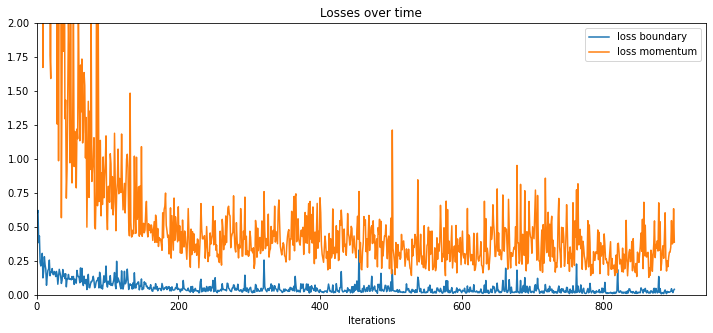

In [ ]:
logger = Logger.load_from('logs/loss_32x32x64_cfix')
fig, ax = logger.plot(fields=['loss boundary', 'loss momentum'],
                      size=(12,5), ylims=(0, 2))
plt.show()

From the plot of the latest training run for about 1500 iterations, we
can see the final loss for the momentum 
hovers very close to around $0.5$.
The boundary loss is much lower, which makes sense
given that all the network needs to learn is to make
the velocity in the region indicated by the mask the
same as the what the boundary conditions dictate.

## Visualizing Flow Fields

### Exporting Tensor/Field data

From what I could find, plotting and visualizing 3D vector fields 
in python (through matplotlib) seems limited and awkward. Although
matlab seems to offer nice visualization tools (like being able to
show the 
[streamline plot](https://www.mathworks.com/help/matlab/ref/streamslice.html)
 of the vector field projected onto a slice 
through the 3D  volume), I do not know matlab very well so I decided to use Mathematica.

The basic pipeline was the following:


1.   Initialize domain with zero field and boundary conditions.
2.   Recurrently apply the model to get the fields $\v{u}^{t+dt}$ 
and $p^{t+dt}$ for the next time step, saving the information
about the domain (like object velocity and position) in a separate
'info' file that contains the name of file where the actual
tensor data (field values, domains masks, etc) is stored.
3. Read in the 'info' file as well the corresponding tensor data in
Mathematica and plot the desired fields.
Here is a link to the [Mathematica Notebook](https://www.wolframcloud.com/obj/4893cd4d-c90c-4e1e-815f-bf697f9b8e16) that
was used, viewable online.

Specific use for the functions is are detailed in the comments.


In [ ]:
def export_tensor(t, tensor_dir, info_file, name=None, comment=None, flags='a'):
    """Write the tensor `t` to disk using numpy's `savetxt` function,
    adding the `comment` and `name` to the `info_file` in the process.

    @param t             tensor to write to disk; will be converted to numpy array
                         so cannot be in CUDA memory
    @param tensor_dir    directory where the tensor data files are written
    @param name          file name for the tensor data file
                         Default: "tensor-<current data and time>"
    @param comment       Comment to write to `info_file` (preceded by a '#')
                         Used to store information about tensor

    @param flags         whether to overwrite the `info_file` when opening
                         for writing.
    """
    with open(info_file, flags) as f:
        # write size
        indicies = [d for d in t.shape]
        f.write(' '.join([str(x) for x in indicies]))
        f.write('\n')
        # write comment if there
        if comment is not None:
            f.write(f'#{comment}\n')
        
        # save data in separate file
        if name is None:
            suf = str(datetime.now()).replace(' ', '_').replace(':', '_')
            name = f'tensor-{suf}'
            
        os.makedirs(tensor_dir, exist_ok=True)
        np.savetxt(f'{tensor_dir}/{name}', t.numpy().reshape((t.shape[0],-1)))
        f.write(f'{name}\n')

def export_fields(indicies, ds, info_file, name=None, tensor_dir='tensors', flags='a'):
    """Exports the fields returned by `DomainsDataset.export` for `indicies`
    and write them to disk using `export_tensor`.
    The comment generated contains information about the domain.
    @param indicies   index of domains to write to disk
    @param ds         `DomainsDataset` object to get domains/fields from
    @param info_file  file to write informationa about domain
    @param name       name of tensor data file
    @param tensor_dir directory to store the tensor data file(s)
    """
    # get tensor data and domain info
    if type(indicies) != list:
        indicies = [indicies]
        
    for index in indicies:
        t = cpu(ds.export(index))
        info =  ds.info[index]
        dtype = info['type']

        # generate comment
        tstr =  lambda t: ' '.join(map(str, t.numpy()))
        comment = ';'.join([f'{k}:{tstr(v) if type(v) is torch.Tensor else v}'
                            for k,v in info.items()])

        export_tensor(t, tensor_dir, info_file, 
                      name=name, comment=comment, flags=flags)
        flags = flags.replace('w','a')
    

def import_tensors(info_file, tensor_dir='tensors'):
    """Import tensors referrenced in `info_file`.
    @param  info_file    file to read for domain information and
                         name of tensor data files
    @param  tensor_dir   directory to search for tensor data files
    """
    arrays = []
    with open(info_file, 'r') as f:
        STATE = 0
        indicies = None

        # while (line := f.readline()):
        while True:
            line = f.readline()
            if not line:
                break

            line = line.strip()
            if line.startswith('#'):
                continue
                
            if STATE == 0:
                # read in shape of tensor
                indicies = [int(x) for x in line.split(' ')]
            else:
                # read file where tensor data is stored
                data = np.loadtxt(f'{tensor_dir}/{line}')
                arrays.append(data.reshape(indicies))
            STATE = (STATE+1)%2
    return torch.tensor(arrays)

The following  `multistep_model` uses the above to functions
to write the data to disk.  The function itself implements
the recurrent application of the model to get the evolution
of the fields as predicted by the model.

The details about the parameters is given in the comments.

In [ ]:
def multistep_model(T, model, ds, indicies, 
                    common_name=None, 
                    info_dir='.',
                    tensor_dir='tensors',
                    update=True, 
                    verbose=False, 
                    save_initial=True,
                    flags='a'):
    """Recurrently applied `model` to the domains
    from `ds` indexed by `indicies` for `T` steps,
    and write them to disk under separate file names
    following: 
                 <info_dir>/<common_name>-<idx>

    The `common_name` parameter can be set to `None`
    to not save anything to disk.

    @param T                number of time steps to advance
    @param model            model to use to compute fields
    @param ds               DomainsDataset to get domains from
    @param indicies         set of domains from `ds` to advance
    @param common_name      prefix for info files
                            set None to not save anything to disk
    @param info_dir         where to save files containg information
                            about the domain
    @param tensor_dir       directory to store tensor data files
    @param update           whether to update the domain (i.e move the object)
                            at each time step
    @param verbose          print information as files are being saved
    @param save_initial     save the intial domain state
    @param flags            whether to overwrite the info files if they exist
    """

    # ensure dir to save info exists, if saving
    if common_name is not None:
        os.makedirs(info_dir, exist_ok=True)

    for t in range(T+1):
        # write fields to disk
        if save_initial and common_name is not None:
            for idx in indicies:
                export_file = f'{info_dir}/{common_name}-{idx}'

                if verbose:
                    print(f'[{t:3}] exporting "{export_file}"', end='\n')
                export_fields([idx], ds, export_file, 
                              tensor_dir=tensor_dir, 
                              flags=flags)

            flags = flags.replace('w', 'a')
        
        # only compute next field T times
        if t >= T:
            continue
        # always save
        save_intial = True
            
        if verbose:
            print(f'[{t:3}] computing new fields', end='\n')

        # compute new fields
        data = ds.peek_batch(indicies)
        a_old, p_old, domain_mask,v_cond, v_cond_mask = cuda(data)

        # interpolate to get values at the cell faces
        v_cond = staggered(v_cond)
        # repeat to get correct dims: (batch, channel, z, y, x)
        v_cond_mask_mac = (staggered(v_cond_mask.repeat(1,3,1,1,1)) == 1).float()
        domain_mask_mac = (staggered(domain_mask.repeat(1,3,1,1,1)) >= 0.5).float()

        # predict new a and p field
        a_new, p_new = model(a_old, p_old, domain_mask, v_cond, v_cond_mask)
        # update dataset with new field
        ds.recycle_batch(indicies, a_new, p_new, update=update)

Initialize empty dataset and manually configure the domain we want, then call `multi_step` to advance and write them to disk.

In [ ]:
ds2 = DomainsDatset((32,32,64),size=3,
                   max_cylinder_length=6,
                   max_cylinder_radius=6,
                   max_sphere_radius=6,
                   max_box_radius=6,
                   
                   max_bd_speed=1,
                   max_ang_speed=1,
                   brown_speed=0,
                   brown_motion=False,
                
                   mu=5,
                   rho=0.2)
# common params
test_params = {'v_flow': -1, 'pos':(16,16,25), 'velocity':(0,0,-1)}

ds2.reset_domain(0, type="box", 
                   dim=(6,6,6),
                   **test_params)

ds2.reset_domain(1, type="cylinder", 
                   omega=2,
                   dim=(6,6),
                   **test_params)

ds2.reset_domain(2, type="sphere",
                   radius=6,
                   **test_params)
                   
multistep_model(20, model, ds2, [0,1,2], 
                common_name='64_test_fast_delta', 
                info_dir='info',
                tensor_dir='tensors',
                flags='w', 
                verbose=True)

### Examples

#### Static Case

In all the following examples, the object's velocity was zero (i.e 
$\v{u}_d = \v{0}$ at the their surface except for the cylinder which is
spinning). The boundary condition at the boundaries were $\v{u}_d = (-1, 0, 0)$, so fluid flowing in from the $-\hat{\v{\text{x}}}$ direction.
The intial position of all the objects were the same, near the start of
the $x$-axis and in the middle of $y$- and $z$-axis.

##### Spinning Cylinder

Below is a plot of the $\v{u}$ after 20 time steps, $t = 20$.
The plot shows what the domain mask for a cylinder actually look
like if it were drawn voxel-by-voxel. It does not look that great
and it offer no better insight, so subsequent plots will show
a idealized shape at the same position and with the same dimensions.

Although this sort of plot is not as easy to read, we can see that on the
bottom face of the box, the field is almost completely pointing in the
$-\hat{\v{\text{x}}}$ direction as the boundary condition in that
region would specify. It doesn't seem to be the case at the region
near the place $x=64$ though.


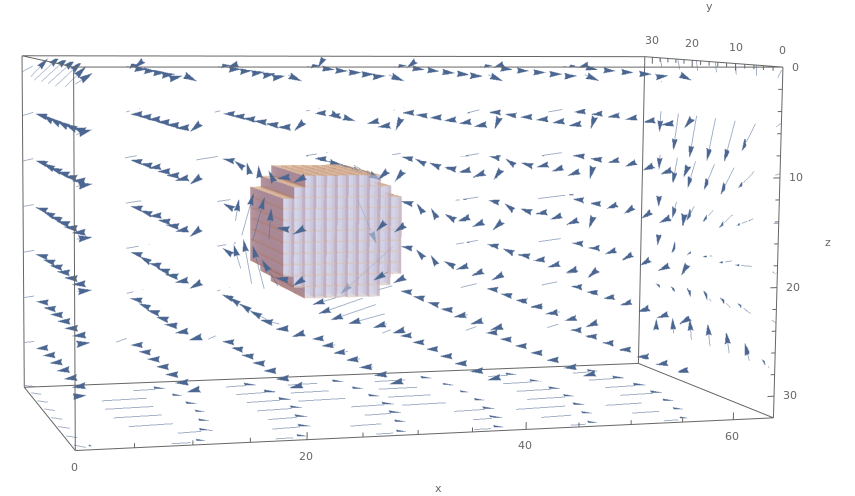

Below is a pressure density plot if we slice the volume along
$y=15$, right down the middle of the cylinder. The region
where the plan would intersect the cylinder is shown as a black circle.
The model's prediction have _some_ physical basis here, since
we expect there to get regions of low/high pressure around
a spinning cylinder in a moving fluid.

In this plot, the fluid would be flowing from the top and the cylinder
would be spinning clockwise. We expect there to be a region
of high pressure to the _left_ of the circle and low pressure to the
_right_ of the circle because the fluid would slow down or speed up, repesctively, due to viscous forces. We can see inklings of that
happening here, if we look hard enough.

It is also possible that the model's prediction are actually mostly 
correct! We would probably need to verify the correctness of the model's
predictions with an actual fluid solver.

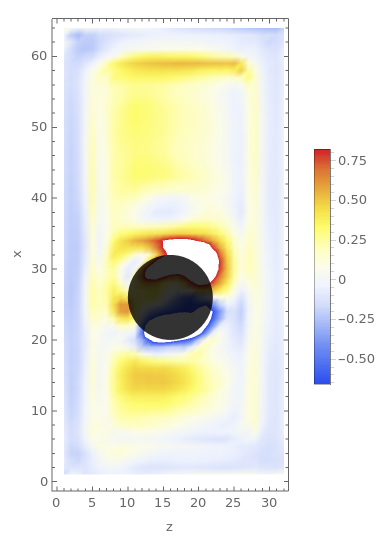

Below is a close-up stream-line plot of the $\v{u}$ field near the
cylinder for the same $y=15$ slice. We can really see here that
the model has gotten the part where the fluid slows down and speeds up
to the left and right  of the circle correct. The streamlines
are spaced further apart of the left and pointed in the correct direction.
On the right, the streamline are closely spaced, so the magnitude is higher
as we would expect.

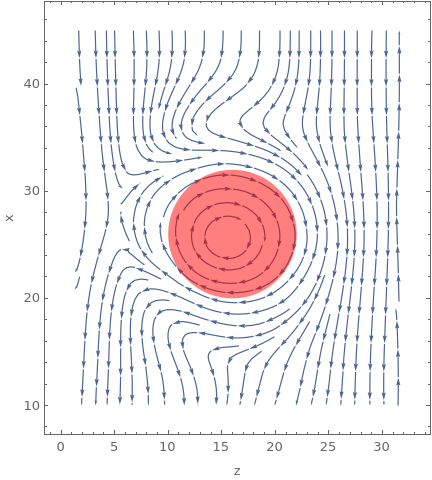

The last plot for this example shows the velocity field plotted along
the center planes. Looking at how we basically have fluid
that is coming in towards the cylinder being directed upwards, it
makes sense why the pressure would be higher in that region. 
I would need to verify this with a fluid-solver would to be confident 
though.

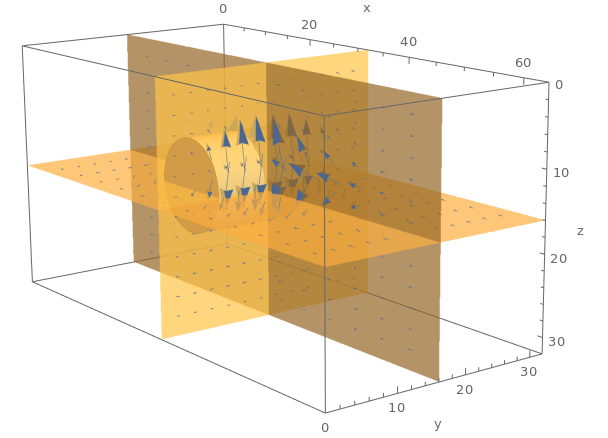

##### Box

Same as before, the velocity field at $t=20$ along $y=15$ slice.
The global view
looks about right, but again hard to make a good judgement without
having the output a fluid-solver handy.

From the close-up view of the velocity field near the box left and right
edges of the box are is apparently has large mangitude, reflected
in the high density of streamlines.
This matches the lower density for the region shown in the pressure 
density plot, since we expect fast moving fluids to have lower
hydrostatic pressure.

I would have expected the top of the square to have higher pressure though.

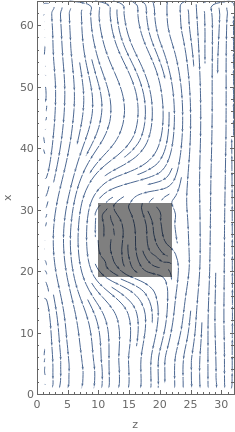
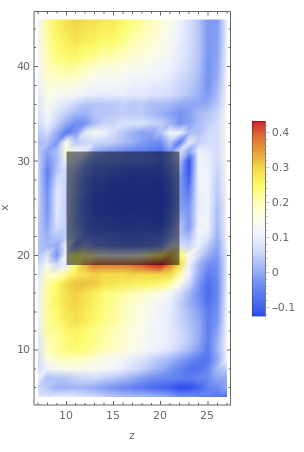
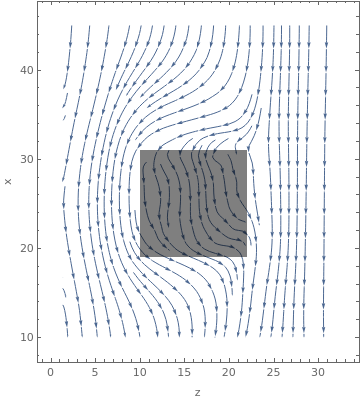

From this view, we can see that the model did a pretty good job satisfying the boundary conditions on the edges of the volume.

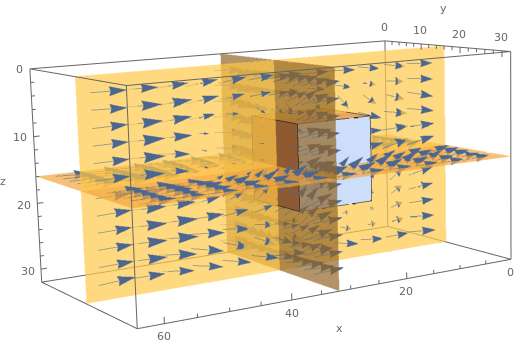

#### Sphere

Nothing unique to be said about the sphere, except that the high
pressure regions right on top and bottom of the sphere sound right, but
that red region of really high pressure on the top doesn't sound right.
The $z$ and $y$ axes should be symmetric here, so not sure what
could be causing this asymmetry.

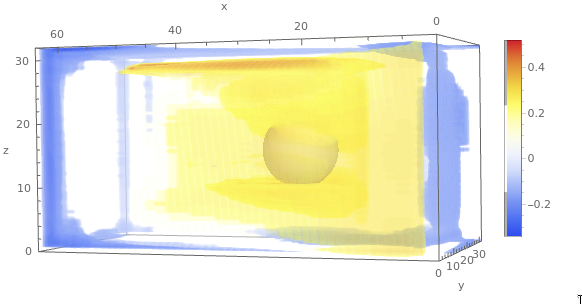
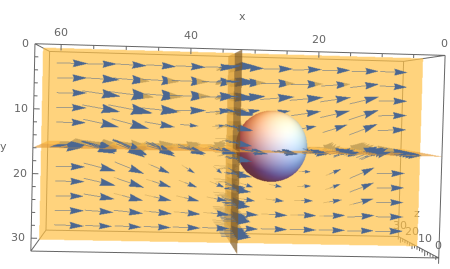

#### Dynamic Case

In the following examples, the object's velocity was 1 in the $x$ direction
(i.e 
$\v{u}_d = (1,0,0)$ at the their surface except for the cylinder for which 
we add the velocity due to rotation). The boundary condition at the
boundaries were the same as before, $\v{u}_d = (-1, 0, 0)$.
The intial position of all the objects was also the same, near the start of
the $x$-axis and in the middle of $y$- and $z$-axis.

##### Spinning Cylinder

This time we have a cylinder spinning clockwise that is also moving
in the positive $x$ direction.
It is interesting to see the fluid getting 'dragged' by the cylinder
but then correct its  course once it's near the boundary.

There seems to be something of a turbelence going on near the cylinder,
which seems resonable given the that we have two opposing flows
meeting in one region.

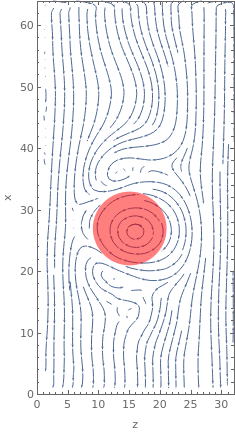
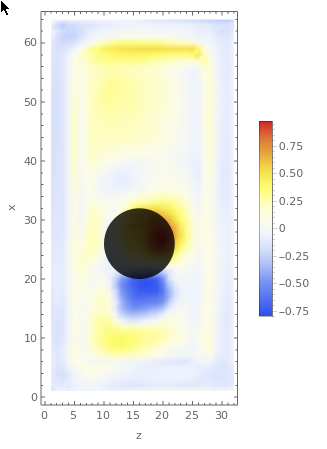

##### Sphere

This time the model indicates a high pressure region ahead, in
the direction that the sphere is heading. This did not really exist
in the static case when the sphere was not moving.
A notable consistency between the pressure and velocity prediction:
for the high pressure region on the top, the corresponding region in the 
velocity graph shows that streamlines
have a lower density.

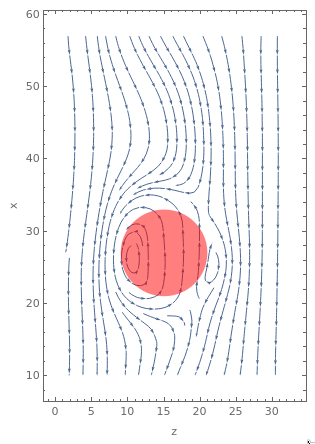
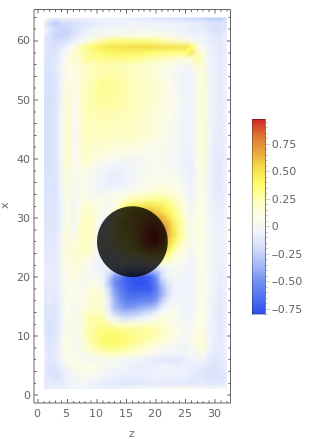

# Conclusion

Throughout the course of this project, I learned
about Foward Convolutional Networks (FCNs) and
why they're used in task where a prediction
must be made for every spatial location in the
output feature map.
I was new to fluid mechanics, so I was able to
learn a lot about Naiver-Stokes, and also
about various approximation and
discretization schemes that are used when doing
these sorts of numerical simulations.
I was also new to unsupervised learning, so going
through this project and learning about how
one might go about creating an appropriate loss
function was rewarding.
I also painfully learned what to look out for when a
deep learning model
just does not want to learn no matter what: check the dimensions!

There are a number of avenues for further work, with
a wide range of expected difficulties.
On the simpler end would be to see if there are
better numerical approximation schemes that can
be used in the calculation of the loss 
to lower the final loss to the order of $10^{-3}$
that the authors of [1] were able to achieve.
Another avenue for extension involves finding
a better way to qualitatively (and possibly
quantitatively) measure the accuracy of the
model's predictions.
One way to do this would be to implement a
fluid solver using traditional numerical 
approximation methods and use its output to
guage, both qualitatively and quantatatively,
how similar the model's prediction are from
that of the fluid solver's.

More involved extensions could include seeing
if there is a way to allow the model to the
evolution of the surface of the fluid. In this case
the evolution of the domain given $\Omega^t$ to
$\Omega^{t+dt}$ was done manually and provided
to the network. This extension would probably
involve allowing the network to predict this,
and calculating the error in a way that would
allow for gradient calculation. Allowing
for free-surface flow would probably open door
for many more applications, but a compelling one
is simply that the visualization of the flow 
would look really nice.

Another really cool avenue for further work 
would to see if this sort of unsupervised learning
approach could be applied to the evolution of
electrically conducting fluids/gasses. This
would fall under 
[Magnetohydrodynamics](https://en.wikipedia.org/wiki/Magnetohydrodynamics) and would now involve
Maxwell's Equations as well Naiver-Stokes.
This would quite nice since those equations are
what govern the motion of the plasma in stars
like our sun!

# References



1.   https://arxiv.org/pdf/2012.11893v1.pdf
2.   https://arxiv.org/pdf/2006.08762.pdf
3.   https://arxiv.org/pdf/1606.06650.pdf
4.   https://cg.informatik.uni-freiburg.de/intern/seminar/gridFluids_fluid_flow_for_the_rest_of_us.pdf
5.   https://raw.githubusercontent.com/kristofe/OpenCLFluids/master/writeup/paper.pdf
6.   https://arxiv.org/pdf/1603.07285v1.pdf
7.   https://arxiv.org/pdf/1411.4038.pdf
8.   https://arxiv.org/pdf/1505.04597.pdf
9.   http://users.encs.concordia.ca/~grogono/Graphics/fluid-5.pdf
10.  https://www.davidstutz.de/wordpress/wp-content/uploads/2014/07/seminar.pdf
11.  https://cs.nju.edu.cn/wujx/paper/CNN.pdf
12.  https://cs231n.github.io/convolutional-networks